In [1]:
import glob, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
%matplotlib notebook
from main import *

In [2]:
#Extracting the SS coverages previously saved and extracted from kMC files
ss_COVG_NONLAT = pd.read_csv('SS_Covg_nonLat.csv')
ss_COVG_LAT = pd.read_csv('SS_Covg_Lat.csv')

In [3]:
#Isolating pressures and ss coverages
Prs_non_lat = ss_COVG_NONLAT.iloc[:,0].to_numpy()
Prs_lat = ss_COVG_LAT.iloc[:,0].to_numpy()
ss_covg_non_lat = ss_COVG_NONLAT.iloc[:,1].to_numpy()
ss_covg_lat = ss_COVG_LAT.iloc[:,1].to_numpy()

In [4]:
#Simulation times from each kMC simulation
t0,tf = 0,750.000000000102

In [5]:
%%time

#Creating NONLAT SSCOVG

#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_NONLAT = []
Prs = Prs_non_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_NONLAT = np.append(MKM_SS_covg_NONLAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 2.63 s, sys: 5.9 ms, total: 2.64 s
Wall time: 2.64 s


In [6]:
%%time
#Performing SS MIKI MKM simulations for non lateral case
from main import *
MKM = MKModel('Atomic.csv','Stoich.csv','Param.csv')
MKM.Thermo_Constraint = 'OFF'
MKM.set_limits_of_integration(t0,tf)
MKM.rate_const_correction='None'
MKM_SS_covg_LAT = []
Prs = Prs_lat
for i in np.arange(len(Prs)):
    MKM.set_rxnconditions(Pr=[Prs[i]])
    MKM_SS_covg_LAT = np.append(MKM_SS_covg_LAT,MKM.get_SS_coverages(print_warning=False)[0])

Mass is conserved. 

CPU times: user 4.58 s, sys: 6.55 ms, total: 4.59 s
Wall time: 4.59 s


In [7]:
rx = len(ss_covg_lat)
Corr_fac = np.zeros(rx) 

In [8]:
import math
MKM_values = MKM_SS_covg_LAT
KMC_values = ss_covg_lat
def corr_func(MKM_values,KMC_values):
    for i in np.arange(rx):
        num = KMC_values[i]
        den = MKM_values[i]
        #Preventing log(0)
        if float(num) == 0:
            num = 1e-20
        if float(den) == 0:
            den = 1e-20

        frac = num/den
        if float(frac) < 0: #(i.e the rates are either being calculated as consumed versus produced)
            frac = abs(frac)

        val = np.log(frac)
        Corr_fac[i] = val
        if math.isinf(val) or math.isnan(val):
            raise Exception('ERROR: inf or nan is present')
    return Corr_fac

In [9]:
correction_values = corr_func(MKM_values,KMC_values)

In [10]:
# selecting history to train from | lateral case
p_cnt = 0.5
train_correction_values = correction_values[:int(len(correction_values) * p_cnt)]
train_Prs_lat = Prs_lat[:int(len(Prs_lat) * p_cnt)]

_rest_Pred_Prs_lat = Prs_lat[int(len(Prs_lat) * p_cnt) :]

## LSTM learning of corrections

In [11]:
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# fix random seed for reproducibilityz
# load the dataset
dataframe = pd.DataFrame(train_correction_values)
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and predict size
# train_size = int(len(dataset) * 0.50) # *******
# predict_size = len(dataset) - train_size
#train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
train = dataset

# reshape into X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
#testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
#testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# fix random seed for reproducibility
# reset_random_seeds()

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
#result = model.fit(trainX, trainY, epochs=10, validation_data=(testX, testY), batch_size=1, verbose=2) # *******
result = model.fit(trainX, trainY, epochs=15, batch_size=1, verbose=2) # *******

# make train prediction
trainPredict = model.predict(trainX)
#testPredict = model.predict(testX)

# Predict future data
predictX = []
firstBatch = train[-look_back:]  # look_back = 4
currentBatch = firstBatch.reshape(1, 1, look_back)

futurePulses = len(_rest_Pred_Prs_lat) #200 # predict 500 future pulses M0
for j in range(futurePulses):
    pred = model.predict(currentBatch)
    predictX.append(pred)
    currentBatch = np.append(currentBatch[:, :, 1:],[pred], axis=2)

futurePredict_arr = np.array(predictX)
futurePredict = np.reshape(futurePredict_arr, (futurePredict_arr.shape[0], -1))

2023-09-19 23:23:51.628170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/15
8/8 - 1s - loss: 0.0713 - 753ms/epoch - 94ms/step
Epoch 2/15
8/8 - 0s - loss: 0.0405 - 9ms/epoch - 1ms/step
Epoch 3/15
8/8 - 0s - loss: 0.0194 - 15ms/epoch - 2ms/step
Epoch 4/15
8/8 - 0s - loss: 0.0085 - 9ms/epoch - 1ms/step
Epoch 5/15
8/8 - 0s - loss: 0.0029 - 11ms/epoch - 1ms/step
Epoch 6/15
8/8 - 0s - loss: 0.0027 - 8ms/epoch - 1ms/step
Epoch 7/15
8/8 - 0s - loss: 0.0027 - 11ms/epoch - 1ms/step
Epoch 8/15
8/8 - 0s - loss: 0.0023 - 10ms/epoch - 1ms/step
Epoch 9/15
8/8 - 0s - loss: 0.0018 - 9ms/epoch - 1ms/step
Epoch 10/15
8/8 - 0s - loss: 0.0019 - 11ms/epoch - 1ms/step
Epoch 11/15
8/8 - 0s - loss: 0.0015 - 10ms/epoch - 1ms/step
Epoch 12/15
8/8 - 0s - loss: 0.0014 - 9ms/epoch - 1ms/step
Epoch 13/15
8/8 - 0s - loss: 0.0012 - 10ms/epoch - 1ms/step
Epoch 14/15
8/8 - 0s - loss: 0.0011 - 10ms/epoch - 1ms/step
Epoch 15/15
8/8 - 0s - loss: 0.0011 - 8ms/epoch - 954us/step
1/1 [==============================] - 0s 14ms/step


In [12]:
Trained_Prs = train_Prs_lat[look_back:-1]
trained_corrections = scaler.inverse_transform(trainPredict)
pred_corrections_lat = scaler.inverse_transform(futurePredict)

# pred_corrections_lat = pred_corrections_lat[look_back:]
# _rest_Pred_Prs_lat = _rest_Pred_Prs_lat[look_back:]

train_ss_covg_lat = []
for i in (np.arange(len(train_Prs_lat))):
    train_ss_covg_lat.append(MKM_SS_covg_LAT[i]*np.exp(train_correction_values[i]))
    
trained_covg_lat = []
for i in (np.arange(len(Trained_Prs))):
    trained_covg_lat.append(MKM_SS_covg_LAT[i]*np.exp(trained_corrections[i]))    
    
pred_lat = []
for i in (np.arange(len(_rest_Pred_Prs_lat))):
    pred_lat.append(MKM_SS_covg_LAT[i]*np.exp(pred_corrections_lat[i]))        
    
pred_lat = pred_lat[3:]
_rest_Pred_Prs_lat = _rest_Pred_Prs_lat[3:]

<IPython.core.display.Javascript object>


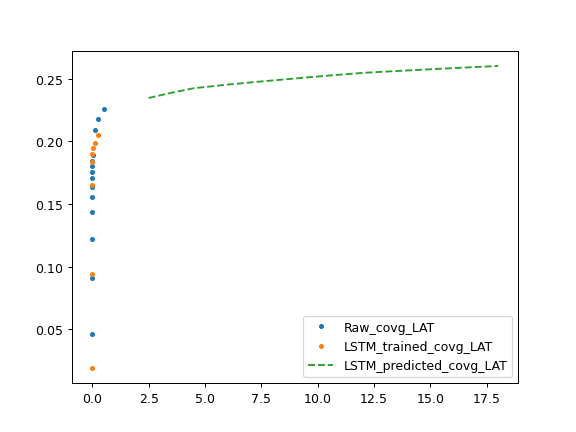

In [13]:
plt.figure()
# plt.plot(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.plot(train_Prs_lat, train_ss_covg_lat, '.', label='Raw_covg_LAT')
plt.plot(Trained_Prs,trained_covg_lat, '.', label='LSTM_trained_covg_LAT')
plt.plot(_rest_Pred_Prs_lat,pred_lat, '--', label='LSTM_predicted_covg_LAT')
plt.legend()
plt.show()

<IPython.core.display.Javascript object>


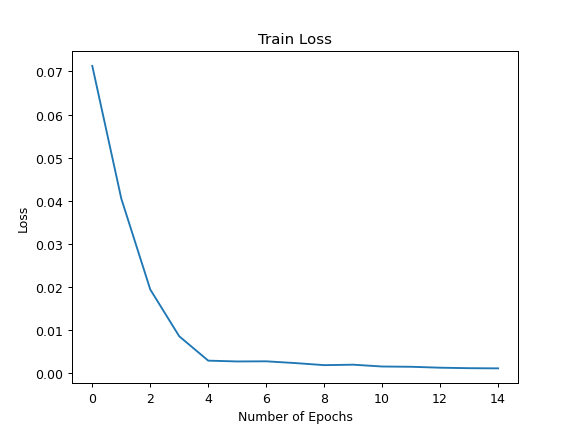

In [14]:
plt.figure()
plt.plot(result.history['loss'])
#plt.plot(result.history['val_loss'])
plt.title('Train Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
# plt.legend(['Train']) #, 'Validation'])
plt.show()

In [15]:
# plt.figure()
# plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
# plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
# plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# # plt.semilogx(Prs_lat,MKM_SS_covg_LAT,'--',label='MKM_LSTM_Fitted_corr isotherm')
# plt.semilogx(Prs_lat,trainPredictPlot,'--',label='Fitted_Train LSTM') #plot
# plt.semilogx(Prs_lat,testPredictPlot,'--',label='Fitted_Test LSTM') #plot
# plt.legend()
# plt.title('CO adsorption_desorption isotherm')
# plt.xlabel('Pressure, [bar]')
# plt.ylabel('CO Coverage, [ML]')
# plt.show()

<IPython.core.display.Javascript object>


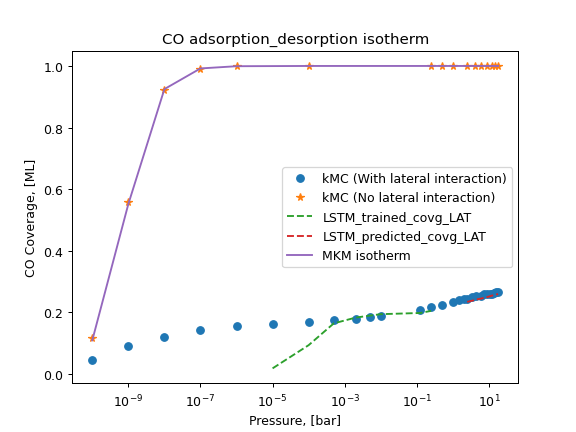

In [16]:
plt.figure()
plt.semilogx(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.semilogx(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.semilogx(Trained_Prs,trained_covg_lat, '--', label='LSTM_trained_covg_LAT')
plt.semilogx(_rest_Pred_Prs_lat,pred_lat, '--', label='LSTM_predicted_covg_LAT')
plt.semilogx(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs_lat,MKM_SS_covg_LAT,'--',label='MKM_LAT_Fitted isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()

<IPython.core.display.Javascript object>


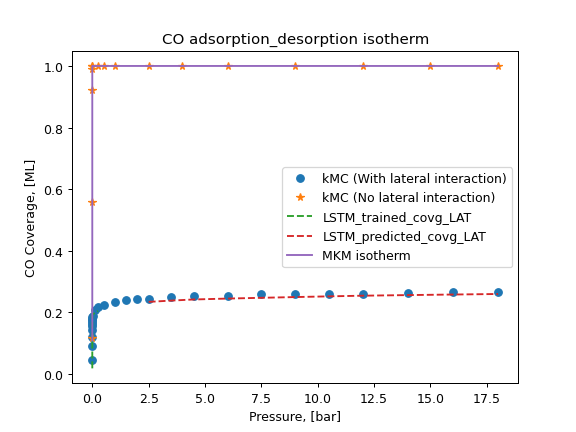

In [17]:
plt.figure()
plt.plot(Prs_lat,ss_covg_lat,'o',label='kMC (With lateral interaction)')
plt.plot(Prs_non_lat,ss_covg_non_lat,'*',label='kMC (No lateral interaction)')
plt.plot(Trained_Prs,trained_covg_lat, '--', label='LSTM_trained_covg_LAT')
plt.plot(_rest_Pred_Prs_lat,pred_lat, '--', label='LSTM_predicted_covg_LAT')
plt.plot(Prs_non_lat,MKM_SS_covg_NONLAT,'-',label='MKM isotherm')
# plt.semilogx(Prs_lat,MKM_SS_covg_LAT,'--',label='MKM_LAT_Fitted isotherm')
plt.legend()
plt.title('CO adsorption_desorption isotherm')
plt.xlabel('Pressure, [bar]')
plt.ylabel('CO Coverage, [ML]')
plt.show()